In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ak-cycle-dataset/output/s1_39/EO.pt
/kaggle/input/ak-cycle-dataset/output/s1_39/SAR.pt
/kaggle/input/ak-cycle-dataset/output/s1_112/EO.pt
/kaggle/input/ak-cycle-dataset/output/s1_112/SAR.pt
/kaggle/input/ak-cycle-dataset/output/s1_115/EO.pt
/kaggle/input/ak-cycle-dataset/output/s1_115/SAR.pt
/kaggle/input/ak-cycle-dataset/output/s1_119/EO.pt
/kaggle/input/ak-cycle-dataset/output/s1_119/SAR.pt
/kaggle/input/ak-cycle-dataset/output/s1_55/EO.pt
/kaggle/input/ak-cycle-dataset/output/s1_55/SAR.pt
/kaggle/input/ak-cycle-dataset/output/s1_107/EO.pt
/kaggle/input/ak-cycle-dataset/output/s1_107/SAR.pt
/kaggle/input/ak-cycle-dataset/output/s1_123/EO.pt
/kaggle/input/ak-cycle-dataset/output/s1_123/SAR.pt
/kaggle/input/ak-cycle-dataset/output/s1_146/EO.pt
/kaggle/input/ak-cycle-dataset/output/s1_146/SAR.pt
/kaggle/input/ak-cycle-dataset/output/s1_63/EO.pt
/kaggle/input/ak-cycle-dataset/output/s1_63/SAR.pt
/kaggle/input/ak-cycle-dataset/output/s1_138/EO.pt
/kaggle/input/ak-cycle-datas

In [19]:
import os
import torch

In [20]:
from torch.utils.data import Dataset

In [4]:
class SAR_EO_Dataset(Dataset):
    def __init__(self,root_dir,transform=None):
        self.root_dir =root_dir
        self.transform =transform


        self.roi_folders =sorted([
            os.path.join(self.root_dir ,name)
            for name in os.listdir(self.root_dir)
            if os.path.isdir(os.path.join(self.root_dir, name))
            
        ])

    def __len__(self):
         return len(self.roi_folders)

    def __getitem__(self, idx):
         roi_path =self.roi_folders[idx]
         sar_path = os.path.join(roi_path, 'SAR.pt')
         eo_path  = os.path.join(roi_path, 'EO.pt')

         sar_tensor =torch.load(sar_path) #eg [C,H,W]
         eo_tensor = torch.load(eo_path)

         if self.transform:
             sar_tensor,eo_tensor =self.transform(sar_tensor,eo_tensor)

         return {"sar":sar_tensor, "eo":eo_tensor}

In [5]:
dataset =SAR_EO_Dataset('/kaggle/input/ak-cycle-dataset/output')

print(f"Total samples: {len(dataset)}")

sample = dataset[0]
print("SAR shape:", sample['sar'].shape)
print("EO shape:", sample['eo'].shape)
print("SAR min/max:", sample['sar'].min().item(), sample['sar'].max().item())
print("EO min/max :", sample['eo'].min().item(), sample['eo'].max().item())


Total samples: 46
SAR shape: torch.Size([752, 224, 224])
EO shape: torch.Size([752, 224, 224])
SAR min/max: -0.11646462976932526 0.0
EO min/max : 6.611764907836914 13.415688514709473


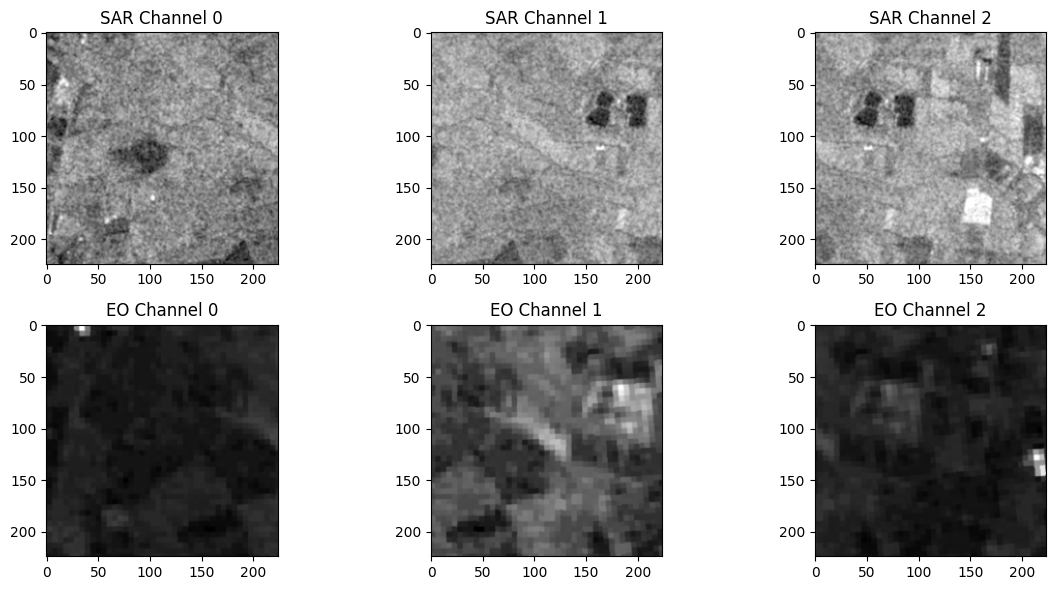

In [15]:
import matplotlib.pyplot as plt

sar_sample = sample['sar']
eo_sample = sample['eo']

# Plot first 3 channels for SAR and EO
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i in range(3):
    axs[0, i].imshow(sar_sample[i], cmap='gray')
    axs[0, i].set_title(f"SAR Channel {i}")
    axs[1, i].imshow(eo_sample[i], cmap='gray')
    axs[1, i].set_title(f"EO Channel {i}")

plt.tight_layout()
plt.show()

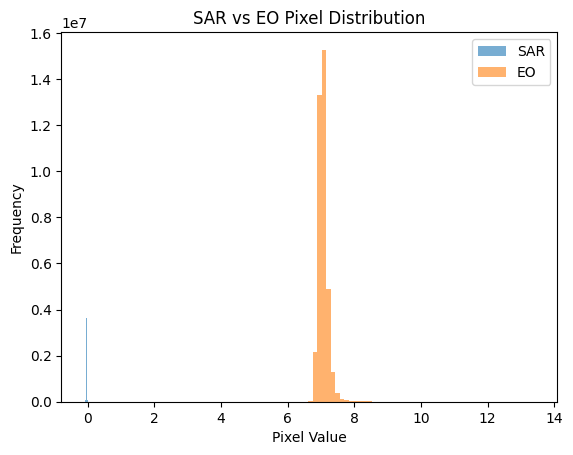

In [7]:
plt.hist(sar_sample.flatten().numpy(), bins=50, alpha=0.6, label='SAR')
plt.hist(eo_sample.flatten().numpy(), bins=50, alpha=0.6, label='EO')
plt.legend()
plt.title("SAR vs EO Pixel Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

** PCA :Visualisation**

In [9]:
sample = dataset[0]
sar = sample['sar']  # shape: [752, 224, 224]
eo  = sample['eo']   # shape: [752, 224, 224]

In [10]:
from sklearn.decomposition import PCA
import torch

def apply_pca(image_tensor, num_components=3):
    """
    image_tensor: [C, H, W] torch tensor
    Returns: [3, H, W] torch tensor
    """
    C, H, W = image_tensor.shape
    # Flatten spatial dims and transpose to [H*W, C]
    flat = image_tensor.reshape(C, -1).T.cpu().numpy()

    # Apply PCA
    pca = PCA(n_components=num_components)
    reduced = pca.fit_transform(flat)  # [H*W, 3]

    # Reshape back to [3, H, W]
    reduced_tensor = torch.tensor(reduced.T).reshape(num_components, H, W)
    return reduced_tensor, pca.explained_variance_ratio_

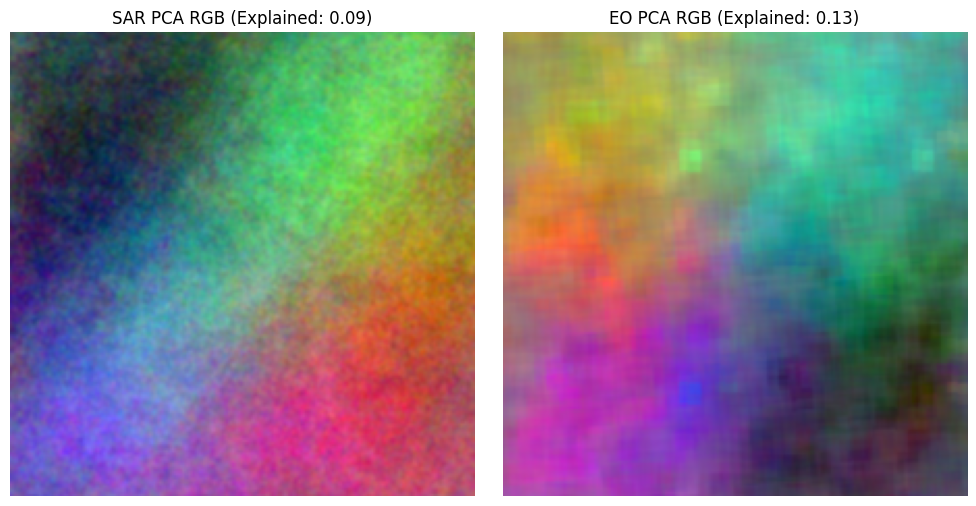

In [11]:
import matplotlib.pyplot as plt

# Apply PCA
sar_rgb, sar_var = apply_pca(sar)
eo_rgb, eo_var = apply_pca(eo)

# Normalize to [0, 1] for visualization
def normalize(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    return (tensor - min_val) / (max_val - min_val)

sar_img = normalize(sar_rgb).permute(1, 2, 0)  # [H, W, 3]
eo_img  = normalize(eo_rgb).permute(1, 2, 0)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sar_img.numpy())
axs[0].set_title(f'SAR PCA RGB (Explained: {sar_var.sum():.2f})')
axs[0].axis('off')

axs[1].imshow(eo_img.numpy())
axs[1].set_title(f'EO PCA RGB (Explained: {eo_var.sum():.2f})')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [12]:
import numpy as np

def apply_pca(image_tensor, num_components=3, return_pca=False):
    C, H, W = image_tensor.shape
    flat = image_tensor.reshape(C, -1).T.cpu().numpy()
    pca = PCA(n_components=num_components)
    reduced = pca.fit_transform(flat)
    reduced_tensor = torch.tensor(reduced.T).reshape(num_components, H, W)
    
    if return_pca:
        return reduced_tensor, pca.explained_variance_ratio_, pca
    else:
        return reduced_tensor, pca.explained_variance_ratio_

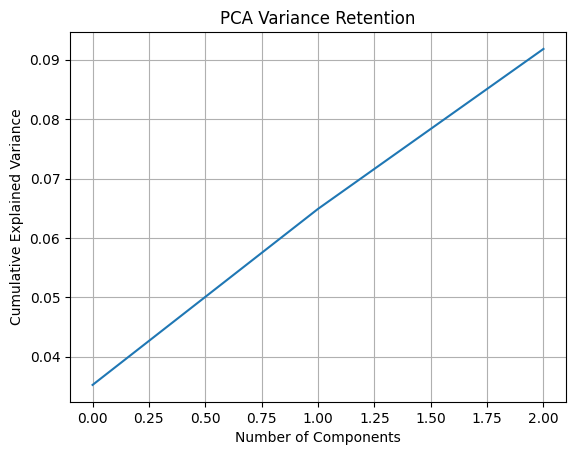

In [26]:
sar_rgb, sar_var, sar_pca = apply_pca(sar, return_pca=True)
plot_variance(sar_pca)


In [27]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.decomposition import PCA

def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

def to_rgb(tensor):
    C, H, W = tensor.shape
    flat = tensor.reshape(C, -1).T.cpu().numpy()
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(flat)
    reduced_tensor = torch.tensor(reduced.T).reshape(3, H, W)
    return normalize(reduced_tensor)

def save_sample_grid(dataset, num_samples=4, save_path='sar_eo_grid.png'):
    sar_images = []
    eo_images = []

    for i in range(min(num_samples, len(dataset))):
        sample = dataset[i]
        sar_rgb = to_rgb(sample['sar'])
        eo_rgb = to_rgb(sample['eo'])
        sar_images.append(sar_rgb)
        eo_images.append(eo_rgb)

    # Interleave SAR and EO: SAR1, EO1, SAR2, EO2, ...
    combined = []
    for sar, eo in zip(sar_images, eo_images):
        combined.extend([sar, eo])

    grid = make_grid(combined, nrow=2 * num_samples // 2, padding=5)

    plt.figure(figsize=(15, num_samples * 1.5))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("SAR vs EO Side-by-Side Grid")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

    print(f"✅ Saved SAR–EO grid with {num_samples} samples to: {save_path}")


In [28]:
save_sample_grid(dataset, num_samples=6, save_path='sar_eo_grid_6samples.png')

✅ Saved SAR–EO grid with 6 samples to: sar_eo_grid_6samples.png


Band_Wise_Variance_Plot

SAR Shape : torch.Size([752, 224, 224])
EO Shape  : torch.Size([752, 224, 224])


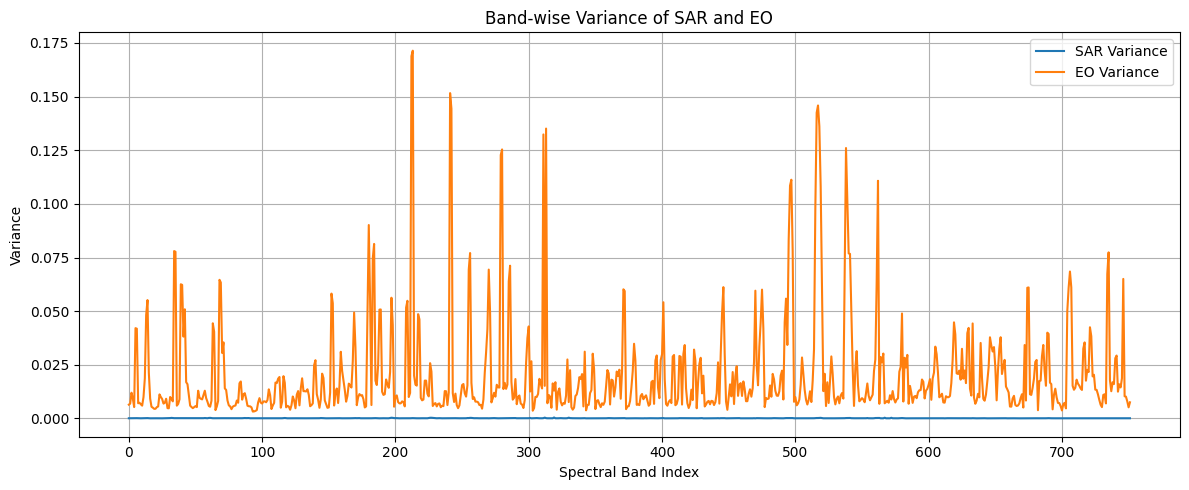

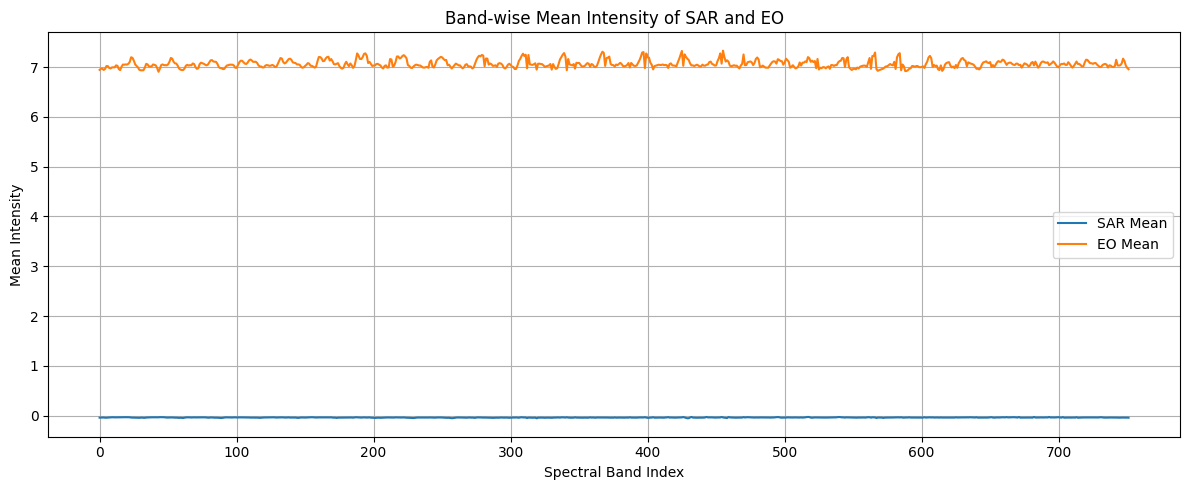

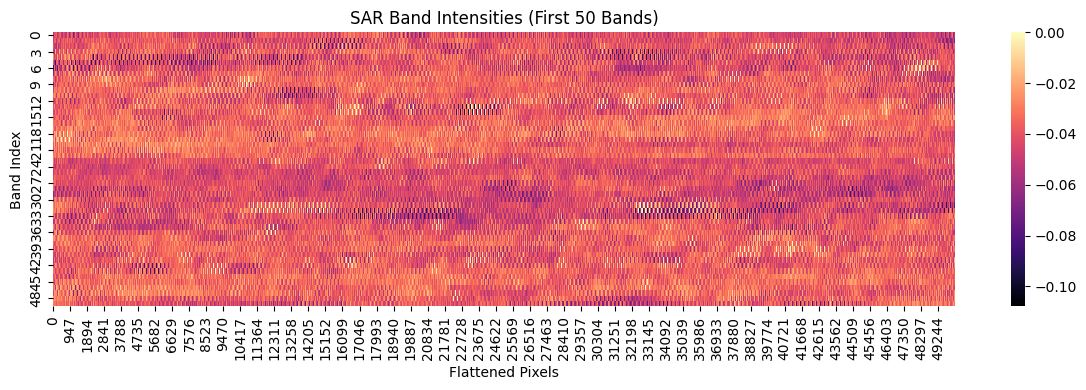

In [31]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load one full tensor
sample_path = "/kaggle/input/ak-cycle-dataset/output/s1_102"
sar = torch.load(os.path.join(sample_path, "SAR.pt"))  # [752, 224, 224]
eo  = torch.load(os.path.join(sample_path, "EO.pt"))   # [752, 224, 224]

# Flatten spatial dimensions
sar_flat = sar.view(sar.shape[0], -1)  # [752, 224*224]
eo_flat  = eo.view(eo.shape[0], -1)

# -------------------------------
# 1. SHAPE VISUALIZATION
# -------------------------------
print("SAR Shape :", sar.shape)
print("EO Shape  :", eo.shape)

# -------------------------------
# 2. BAND-WISE VARIANCE PLOT
# -------------------------------
sar_var = sar_flat.var(dim=1)
eo_var  = eo_flat.var(dim=1)

plt.figure(figsize=(12, 5))
plt.plot(sar_var.numpy(), label="SAR Variance")
plt.plot(eo_var.numpy(), label="EO Variance")
plt.xlabel("Spectral Band Index")
plt.ylabel("Variance")
plt.title("Band-wise Variance of SAR and EO")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 3. BAND-WISE MEAN INTENSITY
# -------------------------------
sar_mean = sar_flat.mean(dim=1)
eo_mean  = eo_flat.mean(dim=1)

plt.figure(figsize=(12, 5))
plt.plot(sar_mean.numpy(), label="SAR Mean")
plt.plot(eo_mean.numpy(), label="EO Mean")
plt.xlabel("Spectral Band Index")
plt.ylabel("Mean Intensity")
plt.title("Band-wise Mean Intensity of SAR and EO")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 4. HEATMAP: VARIANCE DISTRIBUTION
# -------------------------------
plt.figure(figsize=(12, 4))
sns.heatmap(sar_flat[:50], cmap="magma", cbar=True)
plt.title("SAR Band Intensities (First 50 Bands)")
plt.xlabel("Flattened Pixels")
plt.ylabel("Band Index")

plt.tight_layout()
plt.show()

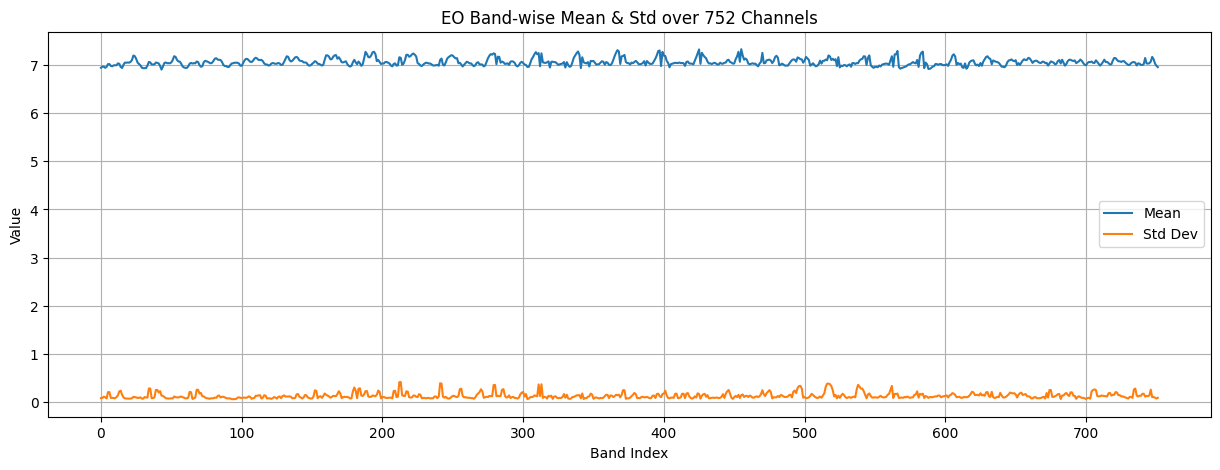

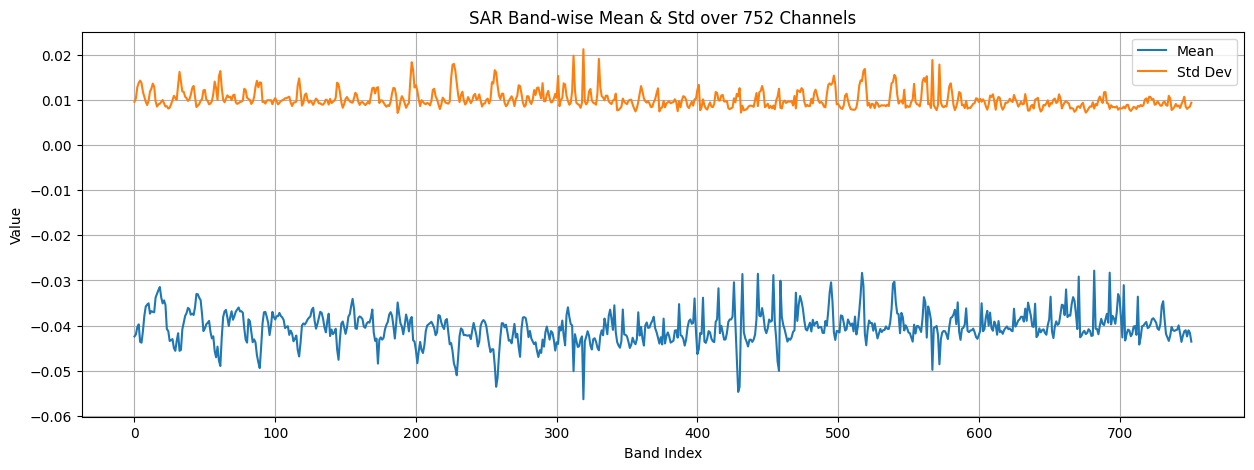

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load a sample EO and SAR tensor
eo_tensor = torch.load("/kaggle/input/ak-cycle-dataset/output/s1_102/EO.pt")  # shape: [752, 224, 224]
sar_tensor = torch.load("/kaggle/input/ak-cycle-dataset/output/s1_102/SAR.pt")

def analyze_bandwise_stats(tensor, label="EO"):
    means = tensor.mean(dim=(1, 2)).numpy()
    stds = tensor.std(dim=(1, 2)).numpy()
    
    plt.figure(figsize=(15, 5))
    plt.plot(means, label='Mean')
    plt.plot(stds, label='Std Dev')
    plt.title(f'{label} Band-wise Mean & Std over 752 Channels')
    plt.xlabel('Band Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot EO & SAR Band Profiles
analyze_bandwise_stats(eo_tensor, label="EO")
analyze_bandwise_stats(sar_tensor, label="SAR")


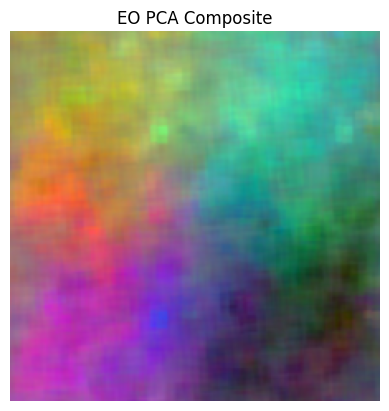

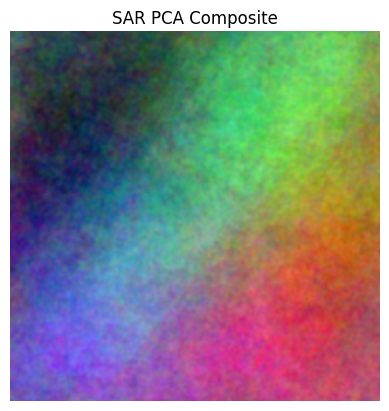

In [18]:
from sklearn.decomposition import PCA

def show_band_pca(tensor, label="EO", n_bands=3):
    h, w = tensor.shape[1:]
    flat = tensor.view(tensor.shape[0], -1).T  # shape: [224*224, 752]
    
    pca = PCA(n_components=n_bands)
    reduced = pca.fit_transform(flat)
    img = reduced.reshape(h, w, n_bands)
    
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.title(f'{label} PCA Composite')
    plt.axis('off')
    plt.show()

show_band_pca(eo_tensor, label="EO")
show_band_pca(sar_tensor, label="SAR")


In [2]:
import torch
import os

# Directory containing your .pt files
data_dir = "/kaggle/input/ak-new-cycle/Preprocessed_Output/0001"

# List of .pt files
pt_files = [f for f in os.listdir(data_dir) if f.endswith(".pt")]

# Load and print shape of each tensor
for pt_file in pt_files:
    file_path = os.path.join(data_dir, pt_file)
    try:
        tensor = torch.load(file_path, map_location='cpu')
        print(f"{pt_file} shape: {tensor.shape}")
    except Exception as e:
        print(f"Error loading {pt_file}: {e}")
        
for pt_file in pt_files:
    print(f"\n📦 File: {pt_file}")
    file_path = os.path.join(data_dir, pt_file)
    
    try:
        tensor = torch.load(file_path, map_location='cpu')

        # Global min and max
        print(f"  🔍 Global Min: {tensor.min().item():.4f}")
        print(f"  🔍 Global Max: {tensor.max().item():.4f}")

        # Per-channel min and max
        print("  📊 Per-channel stats:")
        for i, channel in enumerate(tensor):
            c_min = channel.min().item()
            c_max = channel.max().item()
            print(f"    Channel {i}: min = {c_min:.4f}, max = {c_max:.4f}")
    
    except Exception as e:
        print(f"  ❌ Error loading {pt_file}: {e}")


EO_RGB_NIR.pt shape: torch.Size([4, 256, 256])
SAR.pt shape: torch.Size([2, 256, 256])
EO_NIR_SWIR_RE.pt shape: torch.Size([3, 256, 256])
EO_RGB.pt shape: torch.Size([3, 256, 256])

📦 File: EO_RGB_NIR.pt
  🔍 Global Min: 1.6980
  🔍 Global Max: 26.4824
  📊 Per-channel stats:
    Channel 0: min = 2.9169, max = 21.2353
    Channel 1: min = 4.9552, max = 19.7765
    Channel 2: min = 8.5890, max = 22.0353
    Channel 3: min = 1.6980, max = 26.4824

📦 File: SAR.pt
  🔍 Global Min: -1.2797
  🔍 Global Max: -1.0000
  📊 Per-channel stats:
    Channel 0: min = -1.1788, max = -1.0000
    Channel 1: min = -1.2797, max = -1.0243

📦 File: EO_NIR_SWIR_RE.pt
  🔍 Global Min: 0.4980
  🔍 Global Max: 26.4824
  📊 Per-channel stats:
    Channel 0: min = 1.6980, max = 26.4824
    Channel 1: min = 0.4980, max = 14.5686
    Channel 2: min = 2.4980, max = 17.6824

📦 File: EO_RGB.pt
  🔍 Global Min: 2.9169
  🔍 Global Max: 22.0353
  📊 Per-channel stats:
    Channel 0: min = 2.9169, max = 21.2353
    Channel 1: min = 

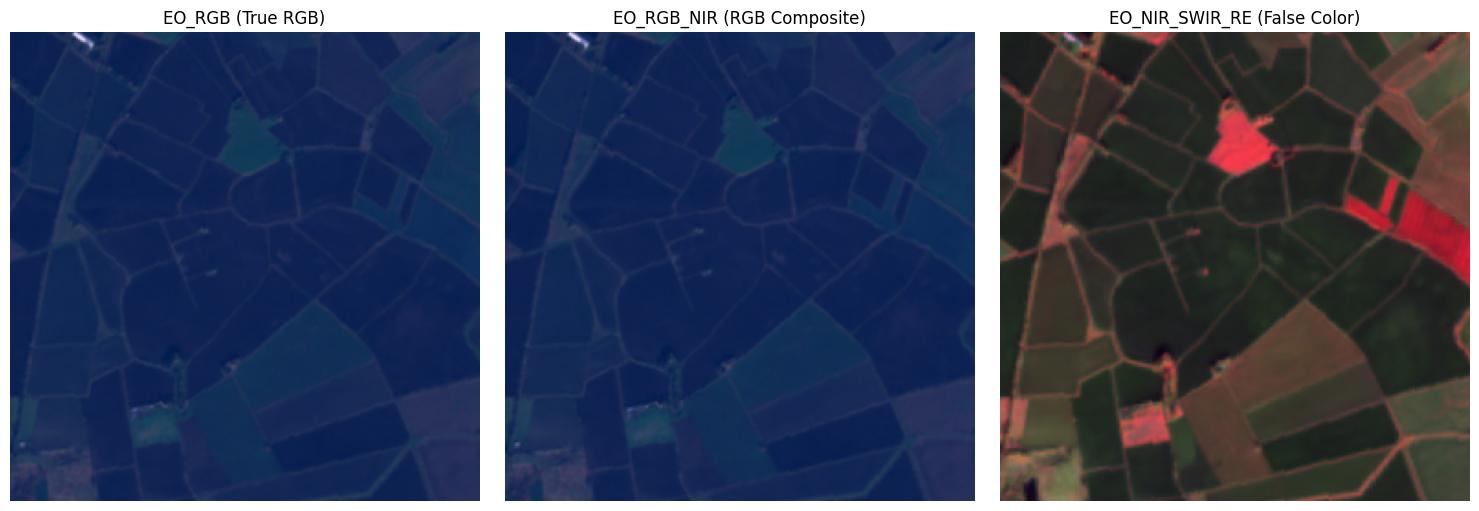

In [5]:

import matplotlib.pyplot as plt

eo_rgb = torch.load(os.path.join(data_dir, "EO_RGB.pt"))               # [3, 256, 256]
eo_rgb_nir = torch.load(os.path.join(data_dir, "EO_RGB_NIR.pt"))       # [4, 256, 256]
eo_nir_swir_re = torch.load(os.path.join(data_dir, "EO_NIR_SWIR_RE.pt"))  # [3, 256, 256]

# Normalize for visualization (0–1 range)
def normalize_for_plot(x):
    x = x.float()
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

# Convert tensor [C, H, W] → [H, W, C] for matplotlib
def to_img(t):
    return normalize_for_plot(t).permute(1, 2, 0).cpu().numpy()

# Prepare images
img_rgb = to_img(eo_rgb)                           # [256, 256, 3]
img_rgb_nir = to_img(eo_rgb_nir[:3])               # First 3 bands as RGB-like
img_false_color = to_img(eo_nir_swir_re)           # Use NIR-SWIR-RE as RGB

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img_rgb)
axs[0].set_title("EO_RGB (True RGB)")
axs[0].axis('off')

axs[1].imshow(img_rgb_nir)
axs[1].set_title("EO_RGB_NIR (RGB Composite)")
axs[1].axis('off')

axs[2].imshow(img_false_color)
axs[2].set_title("EO_NIR_SWIR_RE (False Color)")
axs[2].axis('off')

plt.tight_layout()
plt.show()



In [6]:
print(eo_rgb.shape)

torch.Size([3, 256, 256])


In [7]:

eo_rgb = torch.load("/kaggle/input/ak-new-cycle/Preprocessed_Output/0001/EO_RGB.pt")  # Shape: [3, H, W]

# Global range (entire tensor)
global_min = eo_rgb.min().item()
global_max = eo_rgb.max().item()
print(f"🌐 Global range: min = {global_min}, max = {global_max}")

# Per-channel range
channel_names = ['Red', 'Green', 'Blue']
for i, channel in enumerate(eo_rgb):
    c_min = channel.min().item()
    c_max = channel.max().item()
    print(f"🎨 {channel_names[i]} channel: min = {c_min}, max = {c_max}")

🌐 Global range: min = 2.916933059692383, max = 22.035293579101562
🎨 Red channel: min = 2.916933059692383, max = 21.235294342041016
🎨 Green channel: min = 4.955245494842529, max = 19.776470184326172
🎨 Blue channel: min = 8.589029312133789, max = 22.035293579101562


In [8]:
# Normalize to [-1, 1] using the same [min, max] strategy
eo_rgb_normalized = eo_rgb.clone()
for i in range(3):
    c_min = eo_rgb[i].min()
    c_max = eo_rgb[i].max()
    eo_rgb_normalized[i] = 2 * (eo_rgb[i] - c_min) / (c_max - c_min + 1e-8) - 1

# Range check
print("🎯 CycleGAN normalization range:", eo_rgb_normalized.min().item(), eo_rgb_normalized.max().item())


🎯 CycleGAN normalization range: -1.0 1.0


In [9]:
print(eo_rgb_normalized.min().item(), eo_rgb_normalized.max().item())


-1.0 1.0
